# Feature Engineering
## Early Multi-Disease Risk Prediction System

### Objective
The objective of this notebook is to transform raw health indicators into
meaningful, medically interpretable features that improve model performance
and support early disease risk prediction. Feature engineering focuses on
risk factor aggregation, ordinal encoding, and creation of composite health
risk indices.


In [113]:
import pandas as pd
import numpy as np

pd.set_option("display.max_columns", None)
pd.set_option("display.float_format", lambda x: f"{x:.3f}")


In [114]:
# Load raw dataset
df = pd.read_csv("../data/raw/brfss_2015.csv")

# Quick sanity checks
print("Dataset shape:", df.shape)
df.head()

# Check column names
df.columns


Dataset shape: (253680, 22)


Index(['Diabetes_012', 'HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker',
       'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth',
       'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education',
       'Income'],
      dtype='object')

### STANDARDIZE TARGET VARIABLES

In [115]:
# Create binary diabetes target for early risk prediction
# The diabetes column is encoded as:
# 0 = No diabetes, 1 = Pre-diabetes, 2 = Diabetes
# For early risk prediction, we combine pre-diabetes and diabetes
# into a single binary risk indicator.
df["Diabetes_binary"] = df["Diabetes_012"].apply(lambda x: 1 if x > 0 else 0)

# List final target variables
target_cols = [
    "HeartDiseaseorAttack",
    "Diabetes_binary",
    "Stroke",
    "HighBP"
]

df[target_cols].head()


,HeartDiseaseorAttack,Diabetes_binary,Stroke,HighBP
0,0.000,0,0.000,1.000
1,0.000,0,0.000,0.000
2,0.000,0,0.000,1.000
3,0.000,0,0.000,1.000
4,0.000,0,0.000,1.000


### TARGET DISTRIBUTION RECHECK

In [116]:
# Re-check class distribution after target transformation
# Healthcare datasets are naturally imbalanced, which is expected

for col in target_cols:
    print(f"\n{col} distribution:")
    print(df[col].value_counts(normalize=True))



HeartDiseaseorAttack distribution:
0.000   0.906
1.000   0.094
Name: HeartDiseaseorAttack, dtype: float64

Diabetes_binary distribution:
0   0.842
1   0.158
Name: Diabetes_binary, dtype: float64

Stroke distribution:
0.000   0.959
1.000   0.041
Name: Stroke, dtype: float64

HighBP distribution:
0.000   0.571
1.000   0.429
Name: HighBP, dtype: float64


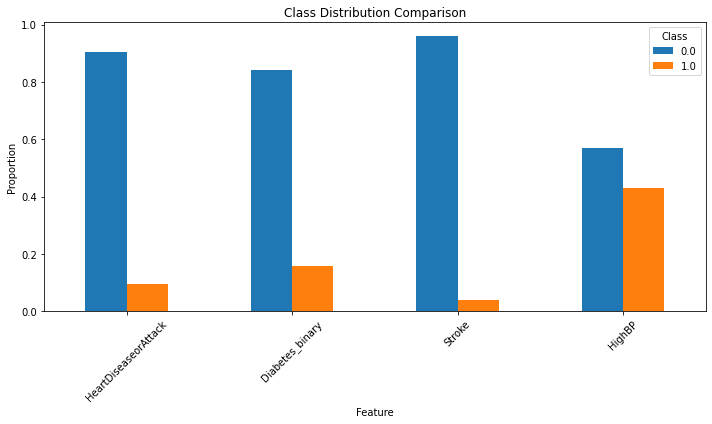

In [149]:
import pandas as pd
import matplotlib.pyplot as plt

distribution_df = pd.DataFrame({
    col: df[col].value_counts(normalize=True)
    for col in target_cols
}).T

distribution_df.plot(kind='bar', figsize=(10,6))
plt.title("Class Distribution Comparison")
plt.xlabel("Feature")
plt.ylabel("Proportion")
plt.xticks(rotation=45)
plt.legend(title="Class")
plt.tight_layout()
plt.show()


### SELECT BASE FEATURE SET

In [117]:
# Base features are common health indicators shared across all diseases
# Using the same feature space ensures a unified ML pipeline

base_features = [
    "Age",
    "Sex",
    "BMI",
    "HighChol",
    "CholCheck",
    "Smoker",
    "PhysActivity",
    "HvyAlcoholConsump",
    "Fruits",
    "Veggies",
    "GenHlth",
    "PhysHlth",
    "MentHlth",
    "DiffWalk",
    "AnyHealthcare",
    "NoDocbcCost"
]

df_base = df[base_features + target_cols]

df_base.head()


,Age,Sex,BMI,HighChol,CholCheck,Smoker,PhysActivity,HvyAlcoholConsump,Fruits,Veggies,GenHlth,PhysHlth,MentHlth,DiffWalk,AnyHealthcare,NoDocbcCost,HeartDiseaseorAttack,Diabetes_binary,Stroke,HighBP
0,9.000,0.000,40.000,1.000,1.000,1.000,0.000,0.000,0.000,1.000,5.000,15.000,18.000,1.000,1.000,0.000,0.000,0,0.000,1.000
1,7.000,0.000,25.000,0.000,0.000,1.000,1.000,0.000,0.000,0.000,3.000,0.000,0.000,0.000,0.000,1.000,0.000,0,0.000,0.000
2,9.000,0.000,28.000,1.000,1.000,0.000,0.000,0.000,1.000,0.000,5.000,30.000,30.000,1.000,1.000,1.000,0.000,0,0.000,1.000
3,11.000,0.000,27.000,0.000,1.000,0.000,1.000,0.000,1.000,1.000,2.000,0.000,0.000,0.000,1.000,0.000,0.000,0,0.000,1.000
4,11.000,0.000,24.000,1.000,1.000,0.000,1.000,0.000,1.000,1.000,2.000,0.000,3.000,0.000,1.000,0.000,0.000,0,0.000,1.000


### FEATURE TYPE CLASSIFICATION

In [118]:
# Explicitly defining feature types helps in:
# - Correct encoding
# - Better preprocessing pipeline design
# - Improved model performance

binary_features = [
    "HighChol", "CholCheck", "Smoker", "PhysActivity",
    "HvyAlcoholConsump", "Fruits", "Veggies",
    "DiffWalk", "AnyHealthcare", "NoDocbcCost"
]

ordinal_features = [
    "Age", "GenHlth"
]

continuous_features = [
    "BMI", "PhysHlth", "MentHlth"
]

print("Binary features:", binary_features)
print("Ordinal features:", ordinal_features)
print("Continuous features:", continuous_features)


Binary features: ['HighChol', 'CholCheck', 'Smoker', 'PhysActivity', 'HvyAlcoholConsump', 'Fruits', 'Veggies', 'DiffWalk', 'AnyHealthcare', 'NoDocbcCost']
Ordinal features: ['Age', 'GenHlth']
Continuous features: ['BMI', 'PhysHlth', 'MentHlth']


### BMI CATEGORY

In [119]:
# BMI categories provide better medical interpretability
# compared to raw BMI values

def bmi_category(bmi):
    if bmi < 18.5:
        return "Underweight"
    elif bmi < 25:
        return "Normal"
    elif bmi < 30:
        return "Overweight"
    else:
        return "Obese"

df_base["BMI_Category"] = df_base["BMI"].apply(bmi_category)

df_base[["BMI", "BMI_Category"]].head()


C:\Users\0701c\AppData\Local\Temp\ipykernel_21616\2226621947.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_base["BMI_Category"] = df_base["BMI"].apply(bmi_category)


,BMI,BMI_Category
0,40.000,Obese
1,25.000,Overweight
2,28.000,Overweight
3,27.000,Overweight
4,24.000,Normal


### LIFESTYLE RISK INDEX

In [120]:
# Lifestyle Risk Index aggregates multiple behavioral risk factors
# Higher values indicate poorer lifestyle habits and higher disease risk

df_base["Lifestyle_Risk_Index"] = (
    df_base["Smoker"] +
    (1 - df_base["PhysActivity"]) +
    df_base["HvyAlcoholConsump"] +
    (1 - df_base["Fruits"]) +
    (1 - df_base["Veggies"])
)

# Validate distribution of the risk index
df_base["Lifestyle_Risk_Index"].value_counts().sort_index()


C:\Users\0701c\AppData\Local\Temp\ipykernel_21616\1631857376.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_base["Lifestyle_Risk_Index"] = (


0.000    68351
1.000    87786
2.000    60326
3.000    28735
4.000     7993
5.000      489
Name: Lifestyle_Risk_Index, dtype: int64

### HEALTH STRESS SCORE

In [121]:
# Health Stress Score captures cumulative physical and mental stress
# This can act as an early indicator of chronic disease risk    

df_base["Health_Stress_Score"] = (
    df_base["PhysHlth"] + df_base["MentHlth"]
)
df_base[["PhysHlth", "MentHlth", "Health_Stress_Score"]].describe()


,PhysHlth,MentHlth,Health_Stress_Score
count,253680.000,253680.000,253680.000
mean,4.242,3.185,7.427
std,8.718,7.413,13.291
min,0.000,0.000,0.000
25%,0.000,0.000,0.000
50%,0.000,0.000,1.000
75%,3.000,2.000,7.000
max,30.000,30.000,60.000


### Verify required columns

In [122]:
# Check if all required columns for Preventive Care Index exist
pci_features = [
    'PhysActivity',
    'Fruits',
    'Veggies',
    'HvyAlcoholConsump',
    'Smoker'
]

print("Missing columns:", [col for col in pci_features if col not in df.columns])


Missing columns: []


### Create Preventive Care Index

In [123]:
# Preventive Care Index (higher = better health behavior)
df['PreventiveCareIndex'] = (
    df['PhysActivity'] +        # 1 if physically active
    df['Fruits'] +              # 1 if consumes fruits
    df['Veggies'] +             # 1 if consumes vegetables
    (1 - df['HvyAlcoholConsump']) +  # 1 if NOT heavy drinker
    (1 - df['Smoker'])               # 1 if NOT smoker
)


### Inspect distribution

In [124]:
# Check distribution of Preventive Care Index
df['PreventiveCareIndex'].value_counts().sort_index()


0.000      489
1.000     7993
2.000    28735
3.000    60326
4.000    87786
5.000    68351
Name: PreventiveCareIndex, dtype: int64

### Create Risk Score

In [125]:
# Risk Score based on major medical risk factors
df['RiskScore'] = (
    df['HighBP'] +
    df['HighChol'] +
    df['BMI'].apply(lambda x: 1 if x >= 30 else 0) +  # Obesity
    df['GenHlth'].apply(lambda x: 1 if x >= 4 else 0) # Poor general health
)


### Map Risk Level (Low / Medium / High)

In [126]:
# Risk Level Mapping
def map_risk(score):
    if score <= 1:
        return 'Low'
    elif score <= 3:
        return 'Medium'
    else:
        return 'High'

df['RiskLevel'] = df['RiskScore'].apply(map_risk)


### Validate Risk Levels

In [127]:
# Check risk level distribution
df['RiskLevel'].value_counts()


Low       145267
Medium     97698
High       10715
Name: RiskLevel, dtype: int64

### Select final features

In [138]:
df.columns

Index(['Diabetes_012', 'HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker',
       'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth',
       'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education', 'Income',
       'Diabetes_binary', 'PreventiveCareIndex', 'RiskScore', 'RiskLevel'],
      dtype='object')

In [139]:
final_features = [
    'Diabetes_012',
    'Age',
    'BMI',
    'HighBP',
    'HighChol',
    'PhysActivity',
    'Smoker',
    'PreventiveCareIndex',
    'RiskScore',
    'RiskLevel',
    'HeartDiseaseorAttack',
    'Stroke'
]

df_final = df[final_features]


### Encode RiskLevel

In [140]:
# Encode RiskLevel for ML models
risk_mapping = {'Low': 0, 'Medium': 1, 'High': 2}
df_final['RiskLevelEncoded'] = df_final['RiskLevel'].map(risk_mapping)


C:\Users\0701c\AppData\Local\Temp\ipykernel_21616\3991782700.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['RiskLevelEncoded'] = df_final['RiskLevel'].map(risk_mapping)


### Confirm Available Disease Targets

In [142]:
# Check if major disease columns exist
disease_targets = [
    'Diabetes_012',
    'HeartDiseaseorAttack',
    'Stroke',
    'HighBP'
]

print("Missing targets:", [col for col in disease_targets if col not in df_final.columns])


Missing targets: []


### Convert Diabetes to Binary

In [143]:
# Convert diabetes into binary: 0 = No, 1 = Pre/Diabetes
df_final['Diabetes_binary'] = df_final['Diabetes_012'].apply(lambda x: 1 if x > 0 else 0)


C:\Users\0701c\AppData\Local\Temp\ipykernel_21616\2869249152.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['Diabetes_binary'] = df_final['Diabetes_012'].apply(lambda x: 1 if x > 0 else 0)


### Define Final Multi-Disease Targets

In [144]:
# Final binary disease targets
multi_targets = [
    'Diabetes_binary',
    'HeartDiseaseorAttack',
    'Stroke',
    'HighBP'
]

df_final[multi_targets].head()


,Diabetes_binary,HeartDiseaseorAttack,Stroke,HighBP
0,0,0.000,0.000,1.000
1,0,0.000,0.000,0.000
2,0,0.000,0.000,1.000
3,0,0.000,0.000,1.000
4,0,0.000,0.000,1.000


### Check Disease Prevalence

In [145]:
# Check class distribution for each disease
for col in multi_targets:
    print(f"\nDistribution of {col}:")
    print(df_final[col].value_counts(normalize=True))



Distribution of Diabetes_binary:
0   0.842
1   0.158
Name: Diabetes_binary, dtype: float64

Distribution of HeartDiseaseorAttack:
0.000   0.906
1.000   0.094
Name: HeartDiseaseorAttack, dtype: float64

Distribution of Stroke:
0.000   0.959
1.000   0.041
Name: Stroke, dtype: float64

Distribution of HighBP:
0.000   0.571
1.000   0.429
Name: HighBP, dtype: float64


### Create Final Modeling Dataset

In [146]:
# Features to use for modeling
model_features = [
    'Age',
    'BMI',
    'HighChol',
    'PhysActivity',
    'Smoker',
    'PreventiveCareIndex',
    'RiskScore'
]

df_model = df_final[model_features + multi_targets]

df_model.head()


,Age,BMI,HighChol,PhysActivity,Smoker,PreventiveCareIndex,RiskScore,Diabetes_binary,HeartDiseaseorAttack,Stroke,HighBP
0,9.000,40.000,1.000,0.000,1.000,2.000,4.000,0,0.000,0.000,1.000
1,7.000,25.000,0.000,1.000,1.000,2.000,0.000,0,0.000,0.000,0.000
2,9.000,28.000,1.000,0.000,0.000,3.000,3.000,0,0.000,0.000,1.000
3,11.000,27.000,0.000,1.000,0.000,5.000,1.000,0,0.000,0.000,1.000
4,11.000,24.000,1.000,1.000,0.000,5.000,2.000,0,0.000,0.000,1.000


### Sanity Check Shape

In [147]:
print("Final modeling dataset shape:", df_model.shape)


Final modeling dataset shape: (253680, 11)


### Save engineered dataset

In [148]:
# Save final engineered dataset
df_final.to_csv('../data/processed/health_risk_engineered.csv', index=False)

print("✅ Engineered dataset saved successfully")

✅ Engineered dataset saved successfully
